# 1.- Imports

In [44]:
# Module import

from __future__ import print_function

from IPython.display import Image
import sys
import pandas as pd

# To use interact -- IPython widget
#
#from ipywidgets import interact, interactive, fixed, interact_manual
#import ipywidgets as widgets


# append to path the folder that contains the analytic scanner
sys.path.append('../GaiaLab/scan/analytic_scanner')
# local imports
#from gaia_analytic_toymodel import *

from scipy import interpolate
import timeit

import frame_transformations as ft
from scanner import Scanner
from satellite import Satellite
from source import Source

import constants as const

from quaternion import Quaternion
from agis import Agis
from agis import Calc_source
from agis_functions import *

from analytic_plots import *

import astropy.units as u
import time
from scipy import sparse as sps
from astropy.coordinates import SkyCoord
import healpy as hp
import pickle
from tqdm import trange

# Ipython magics
%load_ext autoreload
%autoreload 2
#%matplotlib notebook 
# %matplotlib widget
# %matplotlib ipympl
%reload_ext autoreload

DATA_FOLDER = '../data/'
ARCHIVE_FOLDER = DATA_FOLDER+'gaia_archives_data/'
PICKLE_FOLDER = DATA_FOLDER+'pickle_data/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 2.- Satellite and scanner:

In [2]:
# # create all the objects we will need:
# parameters for the notebook
t_init = 0 
t_end =  t_init + 365
my_dt = 1/24 # [days]

# objects
spline_degree = 3

gaia = Satellite(ti=t_init, tf=t_end, dt= my_dt, k=spline_degree)
print('Sat created')

Sat created


In [3]:
double_telescope = True
my_scanner = Scanner(zeta_limit=np.radians(0.5) ,double_telescope=double_telescope) 
print('Scanner created')

Scanner created


# 3.- Some functions

In [5]:
# Functions usefull for this bit:
def generate_angles_of_sources(num_sources):
    # Warning be carefull to what you use to get alpha/delta from vector
    times_for_source = np.linspace(t_init, t_end, num=num_sources, endpoint=True)
    alphas, deltas = ([], [])
    for t in times_for_source:
        noise = np.random.rand(6) *0
        attitude = gaia.func_attitude(t)
        alpha, delta = generate_observation_wrt_attitude(attitude)
        a_P, d_P, a_F, d_F = get_angular_FFoV_PFoV(gaia, t)
        alphas += [alpha +noise[0], a_P+noise[1], a_F+noise[2]]
        deltas += [delta +noise[3], d_P+noise[4], d_F+noise[5]]
    return alphas, deltas


def generate_telescope_positions(num_points = 10000):
    # Generate telescopes positions
    alphas_P, deltas_P, alphas_F, deltas_F = ([], [], [], [])
    for t in np.linspace(t_init, t_end, num=num_points):
        a_P, d_P, a_F, d_F = get_angular_FFoV_PFoV(gaia, t)
        alphas_P.append(a_P-np.pi)
        deltas_P.append(d_P)
        alphas_F.append(a_F-np.pi)
        deltas_F.append(d_F)
    return alphas_P, deltas_P, alphas_F, deltas_F

def transform_twoPi_into_halfPi(deltas):
    deltas = np.array(deltas)
    up_indices = np.where(deltas>np.pi)[0]
    down_indices = np.where(deltas<np.pi)[0]
    deltas[up_indices] -= 2*np.pi
    # deltas[down_indices] += np.pi
    return deltas

# 4.- Visualize scanned zones

### 4.1 Generate coordinates

In [7]:

# alphas, deltas = generate_angles_of_sources()
alphas_P, deltas_P, alphas_F, deltas_F = generate_telescope_positions()

deltas_P = transform_twoPi_into_halfPi(deltas_P)
deltas_F = transform_twoPi_into_halfPi(deltas_F)

### 4.2 Traditional plots

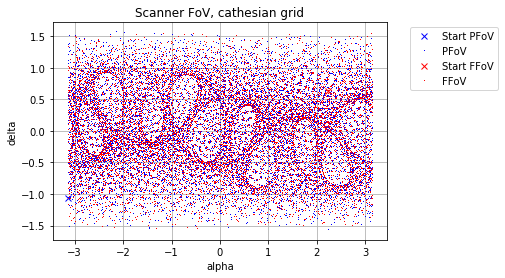

Plotted first plot


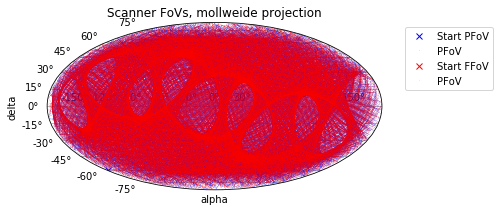

Plotted second plot


/home/zampieri/anaconda3/lib/python3.6/site-packages/matplotlib/projections/geo.py:421: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(y / np.sqrt(2))


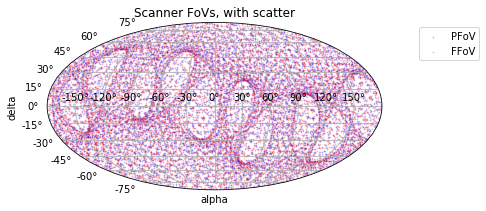

Plotted third plot


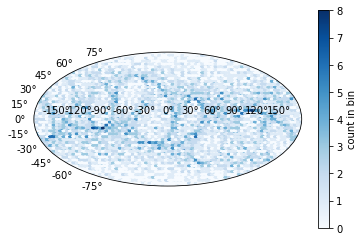

In [8]:
a_min, a_max = (0,-1)

fig = plt.figure()
#plt.plot(aplhas[0], deltas[0], 's')
plt.plot(alphas_P[0], deltas_P[0], 'bx', label='Start PFoV')
plt.plot(alphas_P[a_min : a_max], deltas_P[a_min : a_max], 'b,', label='PFoV')
plt.plot(alphas_F[0], deltas_F[0], 'rx', label='Start FFoV')
plt.plot(alphas_F[a_min : a_max], deltas_F[a_min : a_max], 'r,', label='FFoV')

"""plt.plot(alphas[0]-np.pi, deltas[0], 'gs', label='sources')
for a,d in zip(alphas[1:], deltas[1:]):
    plt.plot(a-np.pi, d, 'gs')"""

plt.title("Scanner FoV, cathesian grid")
plt.legend(loc=9, bbox_to_anchor=(1.2, 1))
plt.grid(True), plt.xlabel('alpha'), plt.ylabel('delta')
plt.show()

print('Plotted first plot')
# ------------------------------ Separation  ----------------------------------------------

fig = plt.figure()
plt.subplot(111, projection="mollweide")
#plt.plot(aplhas[0], deltas[0], 's')
plt.plot(alphas_P[0], deltas_P[0], 'bx', label='Start PFoV')
plt.plot(alphas_P[a_min : a_max], deltas_P[a_min : a_max], 'b,', label='PFoV', alpha=0.1)
plt.plot(alphas_F[0], deltas_F[0], 'rx', label='Start FFoV', linestyle="None")
plt.plot(alphas_F[a_min : a_max], deltas_F[a_min : a_max], 'r,', label='PFoV', alpha=0.1)

# plt.scatter(alphas_F[a_min : a_max], deltas_F[a_min : a_max], marker='.')

"""plt.plot(alphas[0]-np.pi, deltas[0], 'gs', label='sources')
for a,d in zip(alphas[1:], deltas[1:]):
    plt.plot(a-np.pi, d, 'g,')"""

plt.title("Scanner FoVs, mollweide projection")
plt.legend(loc=9, bbox_to_anchor=(1.2, 1))
plt.grid(True), plt.xlabel('alpha'), plt.ylabel('delta')
plt.show()
fig.savefig('./figures/tmp/Mollweide_scanner_positions')


print('Plotted second plot')
# ------------------------------ Separation  ----------------------------------------------

fig = plt.figure()
plt.subplot(111, projection="mollweide")
#plt.plot(aplhas[0], deltas[0], 's')
# plt.plot(alphas_P[0], deltas_P[0], 'bx', label='Start PFoV')
# plt.plot(alphas_P[a_min : a_max], deltas_P[a_min : a_max], 'b,', label='PFoV', alpha=0.1)
# plt.plot(alphas_F[0], deltas_F[0], 'rx', label='Start FFoV', linestyle="None")
# plt.plot(alphas_F[a_min : a_max], deltas_F[a_min : a_max], 'r,', label='PFoV', alpha=0.1)

plt.scatter(alphas_P[a_min : a_max], deltas_P[a_min : a_max], 
            marker='.', color='b', s=3, label='PFoV', alpha=0.2)
plt.scatter(alphas_F[a_min : a_max], deltas_F[a_min : a_max], 
            marker='.', color='r',s=3, label='FFoV', alpha=0.2)

"""plt.plot(alphas[0]-np.pi, deltas[0], 'gs', label='sources')
for a,d in zip(alphas[1:], deltas[1:]):
    plt.plot(a-np.pi, d, 'g,')"""

plt.title("Scanner FoVs, with scatter")
plt.legend(loc=9, bbox_to_anchor=(1.2, 1))
plt.grid(True), plt.xlabel('alpha'), plt.ylabel('delta')
plt.show()
fig.savefig('./figures/tmp/Mollweide_scanner_positions')


print('Plotted third plot')
# ------------------------------ Separation  ----------------------------------------------
fig = plt.figure()
plt.subplot(111, projection="mollweide")
plt.hexbin(alphas_P[a_min : a_max], deltas_P[a_min : a_max], gridsize=90, cmap='Blues')
cb = plt.colorbar(label='count in bin')


"""print('Plotted fourth plot')
# ------------------------------ Separation  ----------------------------------------------
fig = plt.figure()
plt.subplot(111, projection="mollweide")
plt.hist2d(alphas_P[a_min : a_max], deltas_P[a_min : a_max], bins=30)
cb = plt.colorbar(label='count in bin')"""
a=2;

### 4.3 Visualizaton healpy

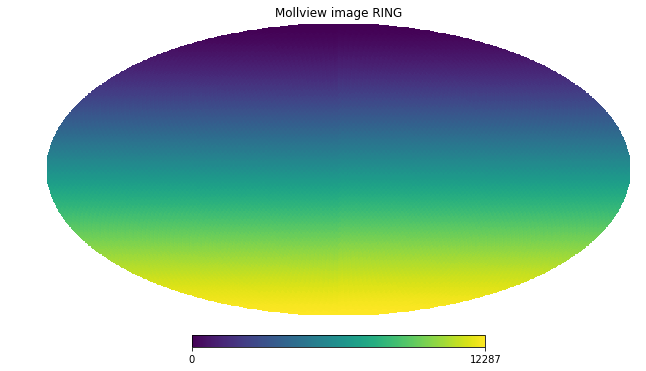

In [9]:
# Basic understanding of how it works:
NSIDE = 32
m = np.arange(hp.nside2npix(NSIDE))
hp.mollview(m, title="Mollview image RING")

In [10]:
# some testing
c = SkyCoord(ra=3, dec=1, frame='icrs', unit='rad')
print(c.icrs.ra.value, c.icrs.dec.value)
c.icrs.ra, c.icrs.dec

171.88733853924697 57.29577951308232


(<Longitude 171.88733854 deg>, <Latitude 57.29577951 deg>)

In [11]:
def cat2hpx(ra, dec, nside):
    """
    from --> https://stackoverflow.com/questions/50483279/make-a-2d-histogram-with-healpix-pixellization-using-healpy
    Convert a array of coordinates to a HEALPix map of number counts per resolution
    element.

    :param alpha: [float][rad] right ascencion (0-2*pi)
    :param delta: [float][rad] declination
    :param nside : [int] HEALPix nside of the target map

    :returns hpx_map: [ndarray] HEALPix map of the catalogue number counts in Galactic coordinates
    """

    my_coordinates = SkyCoord(ra=ra, dec=dec, frame='icrs', unit='rad')
    ra, dec = my_coordinates.icrs.ra.value, my_coordinates.icrs.dec.value

    # conver to theta, phi
    theta = np.radians(90. - dec)
    phi = np.radians(ra-180.)

    # convert to HEALPix indices
    indices = hp.ang2pix(nside, theta=theta, phi=phi)

    idx, counts = np.unique(indices, return_counts=True)
    
    # fill the fullsky map
    npix = hp.nside2npix(nside)
    hpx_map = np.zeros(npix, dtype=int)
    hpx_map[idx] = counts

    return hpx_map

<Figure size 432x288 with 0 Axes>

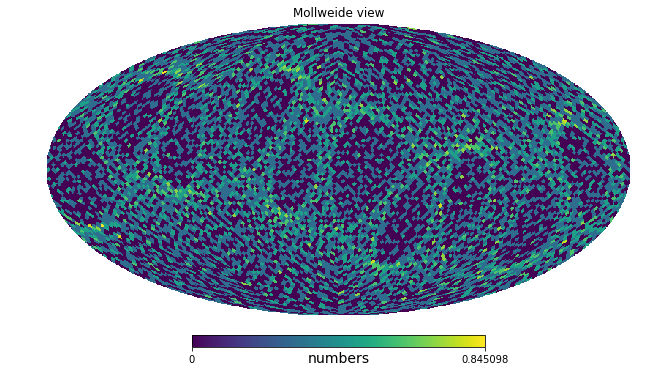

In [12]:
hpx_map = cat2hpx(np.array(alphas_P), np.array(deltas_P), nside=32)
fig = plt.figure()
hp.mollview(np.log10(hpx_map+1), flip='astro', unit='numbers')

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


/home/zampieri/anaconda3/lib/python3.6/site-packages/healpy/projaxes.py:416: RuntimeWarning: invalid value encountered in greater
  w = np.where(d2 > threshold)[0]


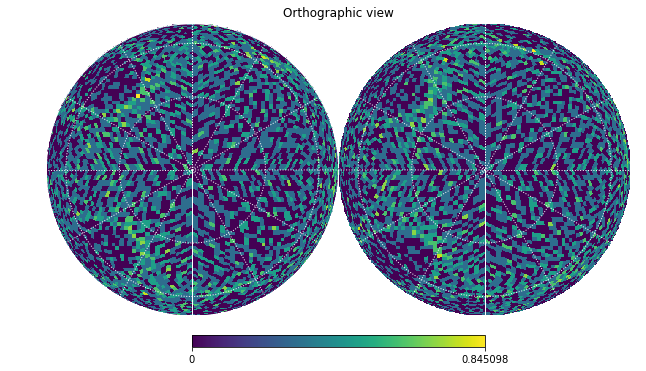

In [13]:
hp.orthview(np.log10(hpx_map+1), rot=[0, 90])
hp.graticule(color='white')

# 5.- Create and scan sources:

### 5.1 Create sources

In [40]:
# create soures from that: 
num_sources = 50
alphas = np.random.rand(num_sources)*360
deltas = np.random.rand(num_sources)*360
sources = []
for n in range(num_sources):
    sources.append(Source(str(n), np.degrees(alphas[n]), np.degrees(deltas[n]), 10, 10, 10, 10))
    # sources.append(Source(str(n), alphas[n], deltas[n], parallaxes[n], mu_alphas[n], mu_deltas[n], mu_radials[n]))
print('Sources created')

Sources created


### 5.2 Scan sources

In [47]:
obs_times = []
calc_sources = []
real_sources = []
scanned_etas, scanned_zetas = ([], [])
for i in trange(len(sources)):
    s = sources[i]
    my_scanner.scan(gaia, s, ti=t_init, tf=t_end)
    my_scanner.compute_angles_eta_zeta(gaia, s)
    """print('zetas:', my_scanner.zeta_scanned)
    print('etas:', my_scanner.eta_scanned)
    print('times:', my_scanner.obs_times)
    print('How many observation time?  {}'.format(len(my_scanner.obs_times)))"""
    if len(my_scanner.obs_times)>0:
        obs_times += my_scanner.obs_times
        # print('Error: ', my_scanner.scanner_error())
        real_sources.append(s)
        scanned_etas += my_scanner.eta_scanned
        scanned_zetas += my_scanner.zeta_scanned
        # calc_sources.append(Calc_source(obs_times=my_scanner.obs_times.copy(), source=s))
    # print('------------------------------------------------------')
sources = real_sources
obs_times = obs_times


100%|██████████| 50/50 [00:20<00:00,  2.21it/s]


### 5.3 Plot scanned sources:

In [55]:
scanned_ra, scanned_dec = ([], [])
for t in obs_times:
    attitude = gaia.func_attitude(t)
    ra, dec = generate_observation_wrt_attitude(attitude)
    scanned_ra.append(ra)
    scanned_dec.append(dec)

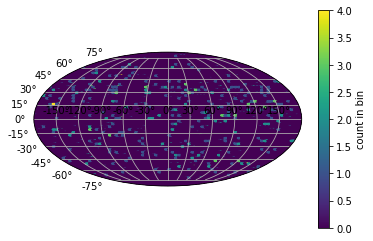

In [56]:
dec_to_plot = transform_twoPi_into_halfPi(scanned_dec)
ra_to_plot = np.array(scanned_ra)-np.pi

fig = plt.figure()

plt.subplot(111, projection="mollweide")
plt.hexbin(ra_to_plot, dec_to_plot, gridsize=90) # , cmap='Blues'
plt.grid()
cb = plt.colorbar(label='count in bin')

### 5.4 Save scanned sources and retrieve them:

In [57]:

with open(PICKLE_FOLDER+'5000_scan2.p', 'wb') as handle:
    # pickle.dump((scanned_ra, scanned_dec), handle, protocol=pickle.HIGHEST_PROTOCOL)
    pass

scanned_ra, scanned_dec = pickle.load( open( PICKLE_FOLDER+'5000_scan.p', "rb" ) )

# 6.- Get sources from gaia-archives

In [34]:
from astropy.io.votable import parse
votable = parse("../data/gaia_archives_downloads/subsampled_10000_sources.vot")